In this notebook I am performing **DATA CLEANING & FEATURE ENGINEERING** on the [`houses`](../../data/houses.csv) dataset.

In [1]:
from ast import literal_eval

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/houses.csv')
print(df.shape)
df.head(3)

(1044, 21)


,property_name,link,society,price,rate,area,areaWithType,bedRoom,bathroom,balcony,...,address,noOfFloor,facing,agePossession,nearbyLocations,description,furnishDetails,features,rating,property_id
0,5 Bedroom House for sale in Sector 70A Gurgaon,https://www.99acres.com/5-bhk-bedroom-independ...,Bptp Visionnaire,5.25 Crore,"₹ 20,115/sq.ft.",(242 sq.m.) Plot Area,Plot area 290(242.48 sq.m.),5 Bedrooms,4 Bathrooms,3+ Balconies,...,"29b, Sector 70A Gurgaon, Gurgaon, Haryana",3 Floors,North-East,0 to 1 Year Old,"['Good Earth City Center 2', 'Kunskapsskolan I...",Do you wish to buy an independent house in sec...,"['1 Wardrobe', '1 Fan', '1 Exhaust Fan', '1 Ge...","['Feng Shui / Vaastu Compliant', 'Private Gard...","['Environment5 out of 5', 'Lifestyle4 out of 5...",K70037724
1,5 Bedroom House for sale in Sector 21A Faridabad,https://www.99acres.com/5-bhk-bedroom-independ...,NaN,5.7 Crore,"₹ 105,751/sq.ft.",(50 sq.m.) Plot Area,Plot area 539(50.07 sq.m.),5 Bedrooms,4 Bathrooms,2 Balconies,...,"Sector 21A Faridabad, Gurgaon, Haryana",2 Floors,NaN,5 to 10 Year Old,NaN,"Hi, we have an independent house/villa availab...","['1 Water Purifier', '5 Fan', '1 Exhaust Fan',...","['Private Garden / Terrace', 'Park', 'Visitor ...",NaN,E69288322
2,10 Bedroom House for sale in Sushant Lok Phase 1,https://www.99acres.com/10-bhk-bedroom-indepen...,NaN,2.1 Crore,"₹ 38,251/sq.ft.",(51 sq.m.) Plot Area,Plot area 61(51 sq.m.),10 Bedrooms,10 Bathrooms,3+ Balconies,...,"Sushant Lok Phase 1, Gurgaon, Haryana",5 Floors,West,0 to 1 Year Old,"['Sector 42-43 metro station', 'Huda city cent...","Monthly rental income is rs1,40,000/- Best opt...","['10 Bed', '3 Fan', '10 Geyser', '2 Light', 'N...","['Maintenance Staff', 'Water Storage', 'Visito...","['Environment5 out of 5', 'Lifestyle5 out of 5...",F69536898


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   property_name    1044 non-null   object
 1   link             1044 non-null   object
 2   society          453 non-null    object
 3   price            968 non-null    object
 4   rate             1005 non-null   object
 5   area             1044 non-null   object
 6   areaWithType     987 non-null    object
 7   bedRoom          987 non-null    object
 8   bathroom         987 non-null    object
 9   balcony          987 non-null    object
 10  additionalRoom   589 non-null    object
 11  address          1031 non-null   object
 12  noOfFloor        967 non-null    object
 13  facing           674 non-null    object
 14  agePossession    987 non-null    object
 15  nearbyLocations  913 non-null    object
 16  description      1036 non-null   object
 17  furnishDetails   743 non-null    

In [4]:
df.isnull().sum()

property_name        0
link                 0
society            591
price               76
rate                39
area                 0
areaWithType        57
bedRoom             57
bathroom            57
balcony             57
additionalRoom     455
address             13
noOfFloor           77
facing             370
agePossession       57
nearbyLocations    131
description          8
furnishDetails     301
features           370
rating             137
property_id          8
dtype: int64

## General steps

In [5]:
df = df.applymap(lambda x: str.lower(x) if isinstance(x, str) else x)

## price

In [6]:
df['price'].str.split().str.get(-1).unique()

array(['crore', 'lac', nan, 'request'], dtype=object)

In [7]:
drop_rows = df[df['price'].str.contains('request') == True].index
df.drop(index=drop_rows, inplace=True)

In [8]:
def handle_price(x: str) -> float:
    if isinstance(x, float):
        return x

    if 'crore' in x:
        return float(x.split(' ')[0]) * 100

    return float(x.split(' ')[0])

In [9]:
df['price'] = df['price'].apply(handle_price)

## rate

In [10]:
df[df['rate'].str.contains('sq.ft.') == False]

,property_name,link,society,price,rate,area,areaWithType,bedRoom,bathroom,balcony,...,address,noOfFloor,facing,agePossession,nearbyLocations,description,furnishDetails,features,rating,property_id


In [11]:
df['rate'] = df['rate'].str.replace(',', '').str.extract(r'(\d+)/sq.ft.').astype(float)

## area

In [12]:
df[df['area'].str.contains('sq.m.') == False]

,property_name,link,society,price,rate,area,areaWithType,bedRoom,bathroom,balcony,...,address,noOfFloor,facing,agePossession,nearbyLocations,description,furnishDetails,features,rating,property_id


**`area` in the dataset has _sq.m._ unit but we require _sq.ft._ unit. So I am going to convert it into _sq.ft._ unit.**

In [13]:
df['area'] = (
    df['area'].str.extract(r'(\d+) sq.m.').astype(float).apply(lambda x: x * 10.76)
)  # convert into (sq. ft.)

## areaWithType

In [14]:
# df['areaWithType'] =
df['areaWithType'].str.extract(r'\W(\d+)\W?').isnull().sum()

0    57
dtype: int64

In [15]:
df[df['areaWithType'].str.contains('super') == True].shape[0]

0

In [16]:
df[df['areaWithType'].str.contains('built') == True].shape[0]

291

In [17]:
df[df['areaWithType'].str.contains('carpet') == True].shape[0]

184

In [18]:
df[df['areaWithType'].str.contains('built') == True]['areaWithType'].values[:10]

array(['plot area 84(70.23 sq.m.)built up area: 83 sq.yards (69.4 sq.m.)carpet area: 82 sq.yards (68.56 sq.m.)',
       'built up area: 6382 (592.91 sq.m.)',
       'built up area: 8000 (743.22 sq.m.)',
       'plot area 215(179.77 sq.m.)built up area: 215 sq.yards (179.77 sq.m.)',
       'built up area: 267 (223.25 sq.m.)',
       'plot area 2700(250.84 sq.m.)built up area: 4000 sq.ft. (371.61 sq.m.)',
       'plot area 272(25.27 sq.m.)built up area: 4800 sq.ft. (445.93 sq.m.)carpet area: 3500 sq.ft. (325.16 sq.m.)',
       'plot area 2400(222.97 sq.m.)built up area: 3400 sq.ft. (315.87 sq.m.)carpet area: 3000 sq.ft. (278.71 sq.m.)',
       'plot area 250(209.03 sq.m.)built up area: 267 sq.yards (223.25 sq.m.)',
       'built up area: 6000 (557.42 sq.m.)'], dtype=object)

In [19]:
# Extract plot area, built up area, carpet area

df['plot_area'] = df['areaWithType'].str.extract(r'plot area\W(\d+)')
df['built_up_area'] = df['areaWithType'].str.extract(r'built up area\W+(\d+)')
df['carpet_area'] = df['areaWithType'].str.extract(r'carpet area\W+(\d+)')

## bedRoom, bathroom, balcony

In [20]:
cols = ['bedRoom', 'bathroom', 'balcony']

for col in cols:
    print(f'{col}: {df[col].unique()}')
    print()

bedRoom: ['5 bedrooms' '10 bedrooms' '21 bedrooms' '12 bedrooms' '20 bedrooms'
 '16 bedrooms' '6 bedrooms' '3 bedrooms' '4 bedrooms' '13 bedrooms'
 '9 bedrooms' '7 bedrooms' '2 bedrooms' '8 bedrooms' nan '1 bedroom'
 '18 bedrooms' '19 bedrooms' '36 bedrooms' '34 bedrooms' '14 bedrooms'
 '11 bedrooms']

bathroom: ['4 bathrooms' '10 bathrooms' '21 bathrooms' '12 bathrooms' '20 bathrooms'
 '5 bathrooms' '16 bathrooms' '6 bathrooms' '3 bathrooms' '7 bathrooms'
 '13 bathrooms' '9 bathrooms' '2 bathrooms' '1 bathroom' '18 bathrooms'
 '8 bathrooms' nan '17 bathrooms' '36 bathrooms' '34 bathrooms'
 '14 bathrooms' '11 bathrooms']

balcony: ['3+ balconies' '2 balconies' '1 balcony' '3 balconies' nan 'no balcony']



In [21]:
for col in cols:
    df[col] = df[col].str.split(' ').str.get(0)

In [22]:
df['balcony'] = df['balcony'].replace('3+', '-1').str.replace('no', '0')

In [23]:
for col in cols:
    df[col] = df[col].astype(float)

## additionalRoom

In [24]:
df['additionalRoom'].value_counts()[:10]

additionalRoom
servant room                                     82
pooja room,study room,servant room,store room    63
others                                           59
pooja room                                       38
pooja room,study room,servant room               34
pooja room,study room,servant room,others        32
store room                                       31
pooja room,servant room                          24
study room                                       19
study room,servant room                          19
Name: count, dtype: int64

In [25]:
additionalRooms = ['study room', 'servant room', 'store room', 'pooja room', 'others']

for col in additionalRooms:
    df[col] = df['additionalRoom'].str.contains(col).fillna(0).astype(int)

In [26]:
df.sample(5)[['additionalRoom', 'study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
389,NaN,0,0,0,0,0
586,NaN,0,0,0,0,0
319,NaN,0,0,0,0,0
950,"study room,servant room",1,1,0,0,0
264,NaN,0,0,0,0,0


## address, description, property_name `->>` sector

In [27]:
df['property_name'].fillna('', inplace=True)
df['address'].fillna('', inplace=True)
df['description'].fillna('', inplace=True)

In [28]:
df.shape

(1034, 29)

In [29]:
df['temp_sector'] = df['address'].add(' ').add(df['description']).add(' ').add(df['property_name'])

In [30]:
df['sector'] = df['temp_sector'].str.replace(r'\W+', ' ', regex=True).str.extract(r'(sector \d+\w)')

**Deal with `property` which does not contains any sector number**

In [31]:
no_sector_series = df[df['temp_sector'].str.contains('sector') == False]['temp_sector']
no_sector_series.shape

(480,)

In [32]:
extra_sectors_naming = {
    '46b': 'sector 46b',
    'dharam colony': 'sector 12',
    'krishna colony': 'sector 7',
    'suncity': 'sector 54',
    'prem nagar': 'sector 13',
    'mg road': 'sector 28',
    'gandhi nagar': 'sector 28',
    'laxmi garden': 'sector 11',
    'shakti nagar': 'sector 11',
    'baldev nagar': 'sector 7',
    'shivpuri': 'sector 7',
    'garhi harsaru': 'sector 17',
    'adarsh nagar': 'sector 12',
    'shivaji nagar': 'sector 11',
    'bhim nagar': 'sector 6',
    'madanpuri': 'sector 7',
    'saraswati vihar': 'sector 28',
    'arjun nagar': 'sector 8',
    'ravi nagar': 'sector 9',
    'vishnu garden': 'sector 105',
    'bhondsi': 'sector 11',
    'surya vihar': 'sector 21',
    'devilal colony': 'sector 9',
    'valley view estate': 'sector 54',
    'mehrauli  road': 'sector 14',
    'jyoti park': 'sector 7',
    'ansal plaza': 'sector 23',
    'dayanand colony': 'sector 6',
    'sushant lok phase 2': 'sector 55',
    'chakkarpur': 'sector 28',
    'greenwood city': 'sector 45',
    'subhash nagar': 'sector 12',
    'malibu town': 'sector 47',
    'surat nagar 1': 'sector 104',
    'mianwali colony': 'sector 12',
    'jacobpura': 'sector 12',
    'rajiv nagar': 'sector 13',
    'rajiv colony': 'sector 33',
    'ashok vihar': 'sector 3',
    'dlf phase 1': 'sector 26',
    'dlf phase 2': 'sector 25',
    'dlf phase 3': 'sector 24',
    'dlf phase 4': 'sector 28',
    'dlf phase 5': 'sector 43',
    'sushant lok phase 3': 'sector 57',
    'sikanderpur metro': 'sector 26',
    'nirvana country': 'sector 50',
    'palam vihar': 'sector 2',
    'new palam vihar': 'sector 110',
    'sushant lok phase 1': 'sector 43',
    'laxman vihar': 'sector 4',
    'laxman vihar phase 2': 'sector 4',
    'rajendra park': 'sector 105',
    'uppals southend': 'sector 49',
    'sohna': 'sector 33',
    'ashok vihar phase 3 extension': 'sector 5',
    'south city 1': 'sector 41',
    'ashok vihar phase 2': 'sector 5',
    "garauli kalan": 'sector 45',
    "bhawani enclave": 'sector 56',
    "iffco chowk": 'sector 29',
    'sai kunj': 'sector 110a',
    'manesar': 'sector 4',
    'shankar vihar': 'sector 104',
    'patel nagar': 'sector 15',
    'dwarka expressway': 'sector 88a',
    'gwal pahari': 'sector 2',
    'paras quartier': 'sector 29',
    'ambience island': 'sector 24',
    'lajpat nagar': 'sector 29',
    'mehrauli': 'sector 29',
    'central park flower valley': 'sector 32',
}

In [33]:
def handle_sector(x: str) -> str | float:
    if not x:
        return np.nan

    for k, v in extra_sectors_naming.items():
        if k in x:
            return v
    else:
        return np.nan

In [34]:
df.loc[no_sector_series.index, 'sector'] = df['temp_sector'].apply(handle_sector)

df['sector'].isnull().sum()

130

**These many value are left to categories with sectors.**

## noOfFloors

In [35]:
df['noOfFloor'].unique()

array(['3 floors', '2 floors', '5 floors', '4 floors', nan, '1 floors',
       '02 floors', '14 floors', '21 floors', '0 floors', '12 floors',
       '27 floors', '13 floors', '6 floors', '10 floors', '20 floors',
       '11 floors', '41 floors', '51 floors', '16 floors', '33 floors'],
      dtype=object)

In [36]:
df['noOfFloor'] = df['noOfFloor'].str.extract(r'(\d+) ').astype(float)

In [37]:
df.rename(columns={'noOfFloor': 'totalFloors'}, inplace=True)

## facing

In [38]:
df['facing'].unique()

array(['north-east', nan, 'west', 'north', 'east', 'south-west', 'south',
       'south-east', 'north-west'], dtype=object)

**`facing` is all good column. There is no need to clean.**

## agePossession

In [39]:
df['agePossession'].unique()

array(['0 to 1 year old', '5 to 10 year old', '1 to 5 year old',
       'within 6 months', '10+ year old', 'undefined', nan, 'jun 2024',
       'dec 2023', 'by 2027', 'under construction', 'oct 2024', 'by 2024',
       'dec 2024', 'within 3 months', 'oct 2023', 'jan 2024'],
      dtype=object)

In [40]:
def categorize_age_possession(value: str) -> str:
    if pd.isna(value):
        return "undefined"
    elif "0 to 1 year old" == value or "within 6 months" == value or "within 3 months" == value:
        return "new property"
    elif "1 to 5 year old" == value:
        return "Relatively New"
    elif "5 to 10 year old" == value:
        return "moderately old"
    elif "10+ year old" == value:
        return "old property"
    elif "under construction" == value or "by" in value:
        return "under construction"

    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])  # <<- Raises ValueError
        return "under construction"
    except ValueError:
        return "undefined"

In [41]:
df['agePossession'] = df['agePossession'].apply(categorize_age_possession)

In [42]:
df['agePossession'].value_counts()

agePossession
moderately old        256
Relatively New        229
old property          219
undefined             199
new property          119
under construction     12
Name: count, dtype: int64

## nearbyLocations

In [43]:
df['nearbyLocations'].isnull().sum()

124

In [44]:
df['nearbyLocations'] = df['nearbyLocations'].apply(
    lambda x: '[]' if isinstance(x, float) else literal_eval(x)
)

In [45]:
df['nearbyLocations'].explode().nunique()

938

In [46]:
df['nearbyLocations'].explode().sample(50).values

array(['apollo cradle hospital gurgaon', 'vatsalya clinic',
       'hdfc bank atm', 'palam vihar railway station',
       'state bank of india sbi', 'triveni hospital gurgaon',
       'vatsalya clinic', 'fat', 'shri shiv shakthi mandir',
       'parashar hospital', 'pushpanjali hospital gurgaon',
       'dr. sarvejeet singh', 'satyam hospital gurgaon',
       'peace taekwondo academy', 'standard chartered atm',
       'best urologist atcomplete family clinic',
       'gurgaon railway station', 'state bank of india',
       'bhatnagar maternity and nursing home', 'hdfc bank',
       'hanuman mandir', 'raj restaurant', 'hdfc bank',
       'kailash nursing home gurgaon', 'dr. kutbuddin akbary',
       'ninex mall', 'sector 55-56 rapid metro station',
       'dwarka expressway', 'nova care clinic', 'walking street',
       'ahmed hospital multi speciality', 'rbs dental clinic',
       'city medical', 'shree krishna hospital gurgaon',
       'manav rachna swimming pool', "mcdonald's",
     

**I need to think about this column `(nearbyLocations)` to create some interesting features out of it.**

**I am not going to implement the previous strategy because it does not categorize many locations.**

## furnishDetails

In [47]:
df['furnishDetails'] = df['furnishDetails'].apply(
    lambda x: '' if isinstance(x, float) else literal_eval(x)
)

In [48]:
distinct_furnish = (
    df['furnishDetails'].explode().str.replace(r'.*\s', '', regex=True).unique().tolist()
)
distinct_furnish = [i for i in distinct_furnish if i and not isinstance(i, float)]
len(distinct_furnish)

17

In [49]:
distinct_furnish

['wardrobe',
 'fan',
 'geyser',
 'light',
 'kitchen',
 'ac',
 'chimney',
 'bed',
 'curtains',
 'table',
 'microwave',
 'fridge',
 'sofa',
 'stove',
 'tv',
 'machine',
 'purifier']

In [50]:
df['furnishDetails'] = df['furnishDetails'].astype(str)
furnish_df = pd.DataFrame()

for furnish in distinct_furnish:
    furnish_df[furnish] = (
        df['furnishDetails'].str.extract(fr'(\d+) {furnish}')[0].fillna(0).astype(int)
    )

In [51]:
furnish_df.sample(10)

,wardrobe,fan,geyser,light,kitchen,ac,chimney,bed,curtains,table,microwave,fridge,sofa,stove,tv,machine,purifier
819,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
692,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0
455,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
609,7,9,6,12,0,7,0,4,0,0,0,1,0,0,5,0,0
239,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
225,2,6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57,6,9,6,17,0,0,0,0,0,0,0,0,0,0,0,0,0
678,0,0,0,0,0,9,1,0,0,0,0,0,0,0,0,0,0
597,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
637,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [52]:
scaler = StandardScaler()
furnish_scaled = scaler.fit_transform(furnish_df)

In [53]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(furnish_scaled)
    wcss_reduced.append(kmeans.inertia_)

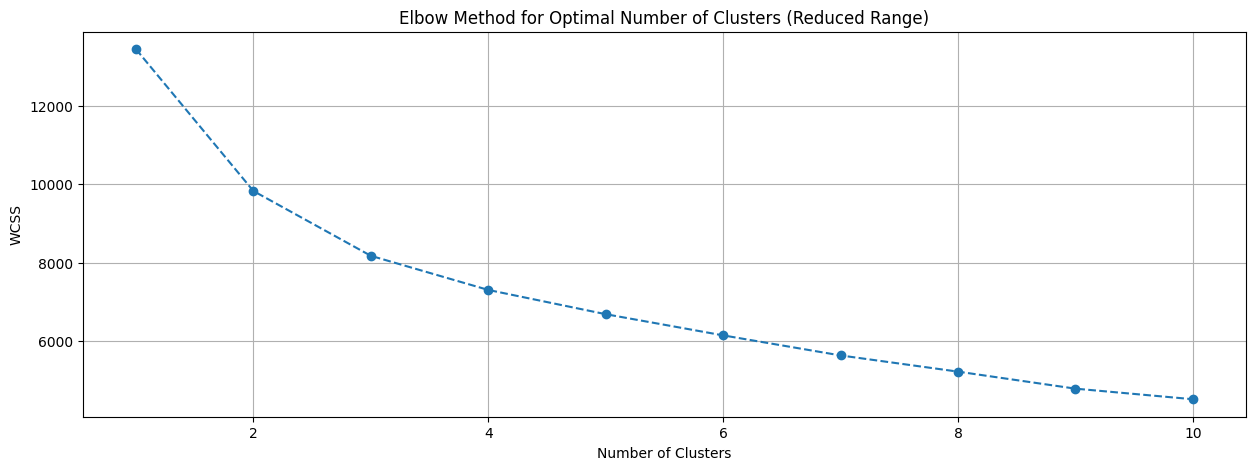

In [54]:
# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(range(1, 11), wcss_reduced, marker='o', linestyle='--')

plt.title('Elbow Method for Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [55]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
kmeans.fit(furnish_scaled)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(furnish_scaled)

In [56]:
df['furnish_type'] = cluster_assignments

In [57]:
pd.set_option('display.max_colwidth', 120)

In [58]:
df[['furnishDetails', 'furnish_type']]

,furnishDetails,furnish_type
0,"['1 wardrobe', '1 fan', '1 exhaust fan', '1 geyser', '1 light', '1 modular kitchen', '1 ac', '1 chimney', 'no bed', ...",0
1,"['1 water purifier', '5 fan', '1 exhaust fan', '1 stove', '8 light', 'no ac', 'no bed', 'no chimney', 'no curtains',...",0
2,"['10 bed', '3 fan', '10 geyser', '2 light', 'no ac', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan...",0
3,"['1 water purifier', '21 fan', '1 fridge', '1 exhaust fan', '1 dining table', '21 geyser', '1 stove', '21 light', '1...",2
4,"['1 water purifier', '1 fridge', '12 fan', '1 exhaust fan', '12 geyser', '1 stove', '12 light', '1 curtains', '12 wa...",2
...,...,...
1039,"['10 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no fan', 'no geys...",0
1040,,0
1041,"['6 fan', '20 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no geyse...",0
1042,"['5 fan', '16 light', 'no ac', 'no bed', 'no chimney', 'no curtains', 'no dining table', 'no exhaust fan', 'no geyse...",0


**furnish_type**

- `0` -> **unfurnished**
- `1` -> **semifurnished**
- `2` -> **furnished**

## General Steps - End

In [59]:
df.columns

Index(['property_name', 'link', 'society', 'price', 'rate', 'area',
       'areaWithType', 'bedRoom', 'bathroom', 'balcony', 'additionalRoom',
       'address', 'totalFloors', 'facing', 'agePossession', 'nearbyLocations',
       'description', 'furnishDetails', 'features', 'rating', 'property_id',
       'plot_area', 'built_up_area', 'carpet_area', 'study room',
       'servant room', 'store room', 'pooja room', 'others', 'temp_sector',
       'sector', 'furnish_type'],
      dtype='object')

In [60]:
df.isnull().sum()

property_name        0
link                 0
society            581
price               76
rate                29
area                 0
areaWithType        57
bedRoom             57
bathroom            57
balcony             57
additionalRoom     445
address              0
totalFloors         77
facing             361
agePossession        0
nearbyLocations      0
description          0
furnishDetails       0
features           360
rating             136
property_id          8
plot_area          255
built_up_area      743
carpet_area        850
study room           0
servant room         0
store room           0
pooja room           0
others               0
temp_sector          0
sector             130
furnish_type         0
dtype: int64

In [61]:
df.drop(
    columns=[
        'areaWithType',
        'additionalRoom',
        'address',
        'furnishDetails',
        'rating',
        'temp_sector',
    ],
    inplace=True,
)

In [62]:
pd.set_option('display.max_columns', None)
df.sample(5)

,property_name,link,society,price,rate,area,bedRoom,bathroom,balcony,totalFloors,facing,agePossession,nearbyLocations,description,features,property_id,plot_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,sector,furnish_type
733,9 bedroom house for sale in sector 50 gurgaon,https://www.99acres.com/9-bhk-bedroom-independent-house-villa-for-sale-in-unitech-south-city-2-sector-50-gurgaon-216...,unitech south city 23.8 ★,588.0,27222.0,2162.76,9.0,9.0,-1.0,3.0,east,Relatively New,"[standard chartered atm, icici bank atm, vatsalya clinic, bones clinic - orthopaedics, meher clinic, dr. naresh pand...","lucrative deal for capital gain savings & rentalssouth city-2, 9bhk floor wise corner & east facing building of 240 ...","['security / fire alarm', 'feng shui / vaastu compliant', 'private garden / terrace', 'water purifier', 'high ceilin...",e69160774,240,NaN,NaN,1,1,0,1,1,sector 50,1
987,5 bedroom house for sale in sector 106 gurgaon,https://www.99acres.com/5-bhk-bedroom-independent-house-villa-for-sale-in-godrej-meridien-sector-106-gurgaon-4000-sq...,godrej meridien,560.0,14000.0,4002.72,5.0,4.0,-1.0,33.0,north-east,new property,"[huda metro station, gurgaon dreamz mall, dwarka expressway, delhi ajmer expressway, euro international school, sect...",sector 106 gurgaon is one of gurgaon's most sought after destination for residential houses and this 5 bhk house in ...,"['centrally air conditioned', 'water purifier', 'security / fire alarm', 'feng shui / vaastu compliant', 'high ceili...",v69168320,4000,NaN,NaN,1,1,1,1,0,sector 106,0
195,4 bedroom house for sale in maruti kunj,https://www.99acres.com/4-bhk-bedroom-independent-house-villa-for-sale-in-maruti-kunj-gurgaon-1700-sq-ft-spid-c69983014,NaN,70.0,4117.0,1700.08,4.0,4.0,1.0,2.0,NaN,moderately old,[],interested to sell independent house/villa.it has spacious 4 bedrooms and 4 bathrooms. .placed at maruti kunj.want t...,NaN,c69983014,1700,NaN,NaN,0,0,0,0,0,NaN,0
1016,9 bedroom house for sale in sector 38 gurgaon,https://www.99acres.com/9-bhk-bedroom-independent-house-villa-for-sale-in-sector-38-rwa-sector-38-gurgaon-1485-sq-ft...,sector 38 rwa,430.0,28782.0,1495.64,9.0,9.0,-1.0,3.0,east,Relatively New,"[rajiv chowk mosque, icici bank atm, state bank of india atm, axis bank atm, hdfc bank atm, dr akram jawed's the upp...","this is a residential house for sale in sector 38 gurgaon, this sector is very near to hospital and national highway...","['feng shui / vaastu compliant', 'private garden / terrace', 'maintenance staff', 'water storage', 'visitor parking'...",e69566242,166,165,164,0,0,0,1,1,sector 38,1
237,5 bedroom house for sale in gandhi nagar,https://www.99acres.com/5-bhk-bedroom-independent-house-villa-for-sale-in-gandhi-nagar-gurgaon-50-sq-ft-spid-x69837440,NaN,45.0,90000.0,53.80,5.0,3.0,0.0,1.0,NaN,undefined,[],best in class property available at gandhi nagar location in gurgaon,NaN,x69837440,NaN,50,NaN,0,0,0,0,0,sector 11,0


## Export dataset

In [63]:
df.to_csv('data/processed/1.0_CLEANING_houses.csv', index=False)